<a href="https://colab.research.google.com/github/rory-smith/Lectures-on-inference-in-GW-astronomy/blob/master/Lecture_1_Intro_to_LIGO_data_and_signals_adelaide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install lalsuite 
#from google.colab import drive
#drive.mount('/content/gdrive')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import numpy as np
import pylab as plt
plt.style.use('default')

from scipy.stats import norm
%matplotlib inline
from IPython.display import set_matplotlib_formats
from IPython.display import clear_output
set_matplotlib_formats('retina')
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mtick
import scipy 
from matplotlib import rc
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d


import sys



font = {'family' : 'sans serif',
        'weight': 'regular',
        'size'   : 20}

rc('font', **font)
#rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (0.4*8*1.9, 0.4*1.9*4*1.2)

In [21]:
import requests, os
import matplotlib.pyplot as plt
from matplotlib import colors

%config InlineBackend.figure_format = 'retina'

try:
    from gwpy.timeseries import TimeSeries
except:
    ! pip install -q "gwpy<2.1"
    ! pip install -q "matplotlib<3.3"
    from gwpy.timeseries import TimeSeries   

In [22]:
import numpy as np
from scipy import signal

# A brief introduction to Advanced LIGO data and black hole signals


* Characteristics of coalescing compact signals
  * Generating time-series signals
  * Generating the Fourier series of a signal
* Open data: GWOSC
  * Data surrounding GW150914
* The strain time series and  Fourier series
* The Power Spectral Density (PSD)




In this lecture we will learn the basics of aLIGO data. Almost all of the questions we can ask about gravitational waves, their source properties, fundamental properties of space-time etc... involves picking out signals in noise. At the point of inferring astrophysical information from our data we have very simple models for the content of the data. Usually, 

* The data contains pure noise $d=n$
* The data contains noise plus a GW signal $d = s+n$


The key concepts here are understanding $\textit{signals}$ and $\textit{noise}$ via their spectral and statistical properties. 




## Objectives


Our objectives will be to 
* Understand how to characterize a coalescing compact binary source (e.g., binary black holes or binary neutron stars)
* Understand the characteristic signals from coalescing compact binaries
* Visualize aLIGO data and understand the $\textbf{strain time series}$
* Understand the $\textbf{spectral content}$ of aLIGO data and the $\textbf{Power Spectral Density (PSD)} $
* Visualize the $\textbf{strain Fourier series}$




# A brief overview of compact binary coalescences and their GW signals 

## Characterizing the source

What can we learn from gravitational waves which originated from a pair of coalescing black holes? If we could extract information perfectly from the gravitational waves we could, in principle, characterize the entire system. The system is characterized by 15 numbers (for coalescing neutron stars there are 17).

<img src="https://docs.google.com/uc?export=download&id=1gcQjmCXFLQOCTT-0xLz36LToXQ9ZeRoJ" width="400">



The 15 quantities which characterize the system are:

* $m_1, m_2$: The masses of the two black holes, usually in units of  solar masses
* $\vec{s^1}=(s^1_x, s^1_y, s^1_z)$ and $\vec{s^2}=(s^2_x, s^2_y, s^2_z)$ : The (dimensionless) spin vectors of each black hole, wiht $0 \leq |\vec{s}^{i}|\leq 1$. A spin of one means the tangential velocity of the spinning black holes is equal to $c$.
* $D$ : The distance to the source (from the detectors), usually in units of mega parsecs (Mpc) or giga parsecs (Gpc)
* RA and DEC: the right ascension and declination of the source (i.e., the sky location)
* $\iota$: the inclination of the binary's orbital plane with respect to the line of sight
* $t_c$: the time at which the black holes merge
* $\phi_c$: the overall phase of the gravitational wave when the black holes merger
* $\psi$: an angle which determines how the two polarizations of the black hole are oriented with respect to the detectors

Binary neutron stars carry (at least) and extra two parameters:

$\Lambda_1$ and $\Lambda_2$: the "Tidal deformability" which encodes how deformed a neutron star can be due to gravitational interaction. The tidal deformability is dependent on the nuclear equation of state of neutron stars and hence learning about $\Lambda$ informs us about nuclear matter at extreme pressure and density. 

A cartoon of the coalescence, together with an example signal is shown below:

<img src="https://docs.google.com/uc?export=download&id=1qd7C_2j0ojUHFqNvP0mj1Eh3gii4AS3R" width="400">



We can explore the effect of these parameters using the following code. 



### Modeling CBC signals in the time domain

The actual models themselves are the result of theoretical work (see lectures by Paul Lasky). For now we'll just assume that the hard work has been done for us and all we need to do is call a function which outputs a model signal, given our input parameters.

In [23]:
import lal
import lalsimulation as lalsim

def time_domain_GWsignal(m1,m2,s1,s2,dist,iota,phi_c):
  longAscNodes = 0 # this is all book keeping
  eccentricity = 0 # Assume circular orbit
  meanPerAno = 0

  WFdict = lal.CreateDict()

  lalsim.SimInspiralWaveformParamsInsertFrameAxis(WFdict, 2)
  lalsim.SimInspiralWaveformParamsInsertPNSpinOrder(WFdict, -1)
  lalsim.SimInspiralWaveformParamsInsertPNTidalOrder(WFdict, -1)
  lalsim.SimInspiralWaveformParamsInsertPNPhaseOrder(WFdict, -1)
  lalsim.SimInspiralWaveformParamsInsertPNAmplitudeOrder(WFdict, -1)
  lalsim.SimInspiralWaveformParamsInsertTidalLambda1(WFdict, 0.0)
  lalsim.SimInspiralWaveformParamsInsertTidalLambda2(WFdict, 0.0)

  f_high = 2048.
  Fs = 2*f_high
  deltaT = 1./Fs
  f_ref = 10 # Reference frequency at which spins are calculated
  f_low = 20 # A low frequency cut off
  
  approx = lalsim.SEOBNRv3 # Approximation scheme in time domain

  hplus, hcross = lalsim.SimInspiralChooseTDWaveform(m1 * lal.MSUN_SI, 
                                                     m2 * lal.MSUN_SI,\
                                                     s1[0], s1[1], s1[2],\
                                                     s2[0], s2[1], s2[2],\
                                                     dist * 1e6 * lal.PC_SI, 
                                                     iota, phi_c,\
                                                     longAscNodes, eccentricity,
                                                     meanPerAno,
                                                     deltaT, f_low, f_ref,\
                                                     WFdict, approx)
  tseries = np.linspace(0,len(hplus.data.data)/Fs,len(hplus.data.data))
  return tseries, hplus.data.data, hcross.data.data

In [24]:
m1,m2= 30,30
s1 = [0.0, 0.0, 0.0]
s2 = [0.0, 0.0, 0.0]
dist = 1500. # Distance in Mpc
iota = 0 # Inclination 
phi_c = 0. # Overall phase

tseries, hplus, hcross = time_domain_GWsignal(m1,m2,s1,s2,dist,iota,phi_c)

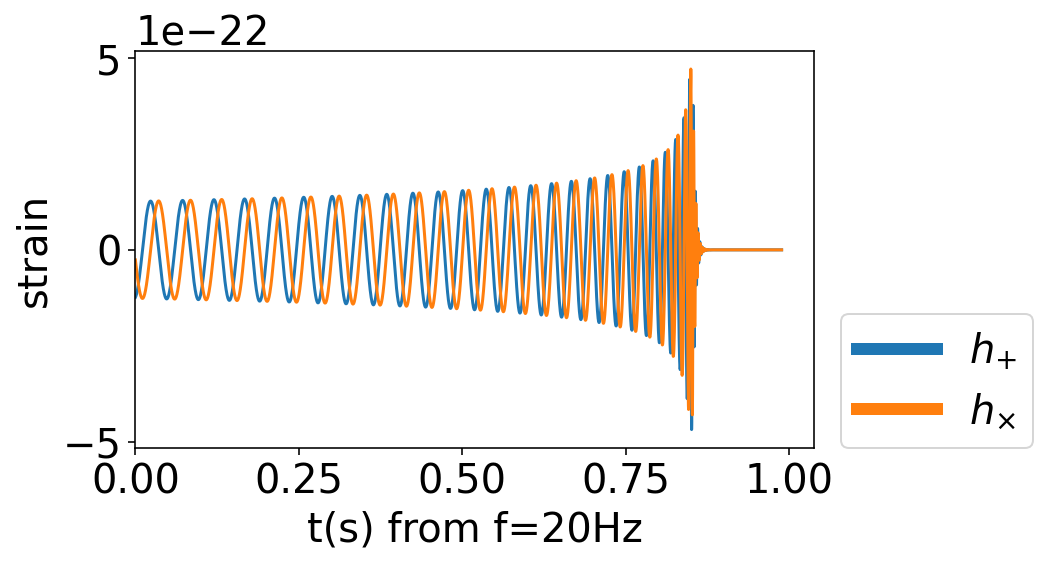

In [25]:
plt.plot(tseries, hplus,label=r'$h_{+}$')
plt.plot(tseries, hcross,label=r'$h_{\times}$')
plt.xlabel('t(s) from f=20Hz')
plt.ylabel('strain')
plt.xlim(0)
plt.legend(loc=(1.04,0))


The strain is a dimensionless quantity. Recall,


---


* $\text{strain} = \frac{\Delta L}{L}$


---


Where $L$ is the arm length of the interferometer.


### Modeling CBC signals in the frequency domain

In [26]:
def frequency_domain_GWsignal(m1,m2,s1,s2,dist,iota,phi_c):
  
  longAscNodes = 0 # this is all book keeping
  eccentricity = 0 # Assume circular orbit
  meanPerAno = 0

  WFdict = lal.CreateDict()

  lalsim.SimInspiralWaveformParamsInsertFrameAxis(WFdict, 2)
  lalsim.SimInspiralWaveformParamsInsertPNSpinOrder(WFdict, -1)
  lalsim.SimInspiralWaveformParamsInsertPNTidalOrder(WFdict, -1)
  lalsim.SimInspiralWaveformParamsInsertPNPhaseOrder(WFdict, -1)
  lalsim.SimInspiralWaveformParamsInsertPNAmplitudeOrder(WFdict, -1)
  lalsim.SimInspiralWaveformParamsInsertTidalLambda1(WFdict, 0.0)
  lalsim.SimInspiralWaveformParamsInsertTidalLambda2(WFdict, 0.0)
  
  
  approx = lalsim.IMRPhenomD
    
  T = 32.
  deltaF = 1./T # Frequency resolution
  f_high = 2048.
  f_low= 20.
  f_ref=20.
  hplus, hcross = lalsim.SimInspiralChooseFDWaveform(m1 * lal.MSUN_SI, 
                                                     m2 * lal.MSUN_SI,\
                                                     s1[0], s1[1], s1[2],\
                                                     s2[0], s2[1], s2[2],\
                                                     dist * 1e6 * lal.PC_SI, 
                                                     iota, phi_c,\
                                                     longAscNodes, 
                                                     eccentricity, meanPerAno,
                                                     deltaF, f_low, f_high,
                                                     f_ref,\
                                                     WFdict, approx)
    
  hp = hplus.data.data # Data as numpy array
  hc = hcross.data.data
  
  fseries = np.linspace(0,f_high, len(hp))
  
  return fseries, hp, hc

In [27]:
m1,m2= 30,30
s1 = [0.0, 0.0, 0.0]
s2 = [0.0, 0.0, 0.0]
dist = 1500. # Distance in Mpc
iota = 0 # Inclination 
phi_c = 0. # Overall phase

fseries, hplus_fdomain, hcross_fdomain = frequency_domain_GWsignal(m1,m2,s1,s2,dist,iota,phi_c)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(20, 3565.775107260926)

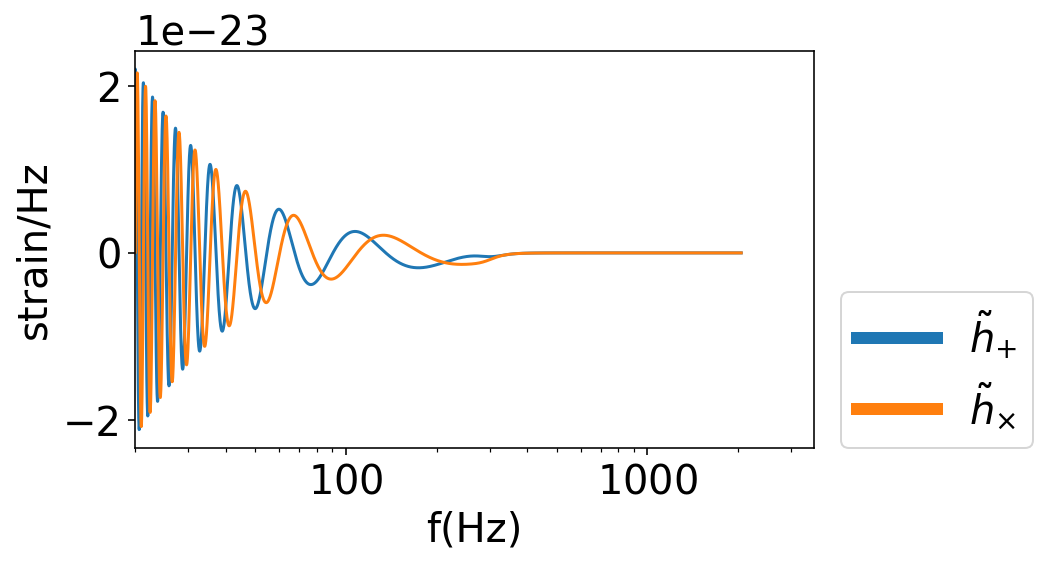

In [28]:
plt.semilogx(fseries, hplus_fdomain,label=r'$\tilde{h}_{+}$')
plt.semilogx(fseries, hcross_fdomain,label=r'$\tilde{h}_{\times}$')
plt.xlabel('f(Hz)')
plt.ylabel('strain/Hz')
plt.legend(loc=(1.04,0))
plt.xlim(20)

(20, 3565.775107260926)

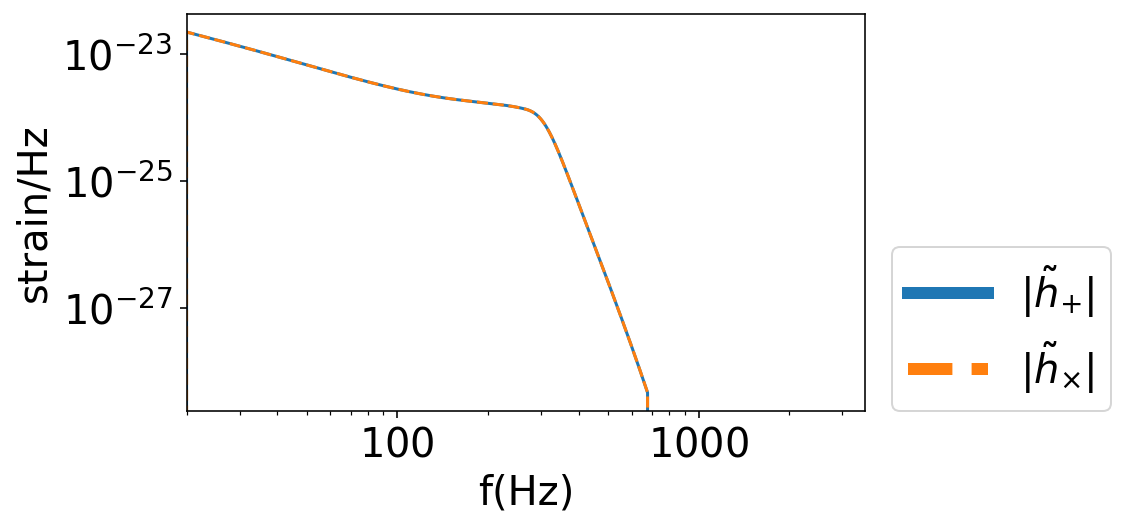

In [29]:
plt.loglog(fseries, np.abs(hplus_fdomain),label=r'$|\tilde{h}_{+}|$')
plt.loglog(fseries, np.abs(hcross_fdomain),label=r'$|\tilde{h}_{\times}|$',
           linestyle='--')
plt.xlabel('f(Hz)')
plt.ylabel('strain/Hz')
plt.legend(loc=(1.04,0))
plt.xlim(20)

# GWOSC: The gravitational-wave open science center

We will begin by retrieving publicly-available aLIGO data from [GWOSC](https://www.gw-openscience.org). We will use a particular data segment -- taken just before the first detected singal GW150914 -- and use this to illustrate the key properties of our data.

The following is based heavily on the examples provided in the [tutorials](https://www.gw-openscience.org/GW150914data/LOSC_Event_tutorial_GW150914.html) section of GWOSC.

For convenience, I've collected some useful data into a single file which can be loaded in for this session.

The file contains the strain time series, and a "best fit" gravitational wave signal that we will use in the next session.

For now, we'll start by looking at the strain time series and build up our intuition for the data.



## Plotting the strain time series from LIGO Hanford and LIGO Livingston

In [30]:
import pandas as pd

In [31]:
# -- Set a GPS time:
t0 = 1126259462.4    # -- GW150914

#-- Choose detector as H1, L1, or V1
detector = 'H1'



from gwosc.locate import get_urls
url = get_urls(detector, t0, t0)[-1]

print('Downloading: ' , url)
fn = os.path.basename(url)
with open(fn,'wb') as strainfile:                 
    straindata = requests.get(url)
    strainfile.write(straindata.content)

Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


### Strain in LIGO Hanford (H1)

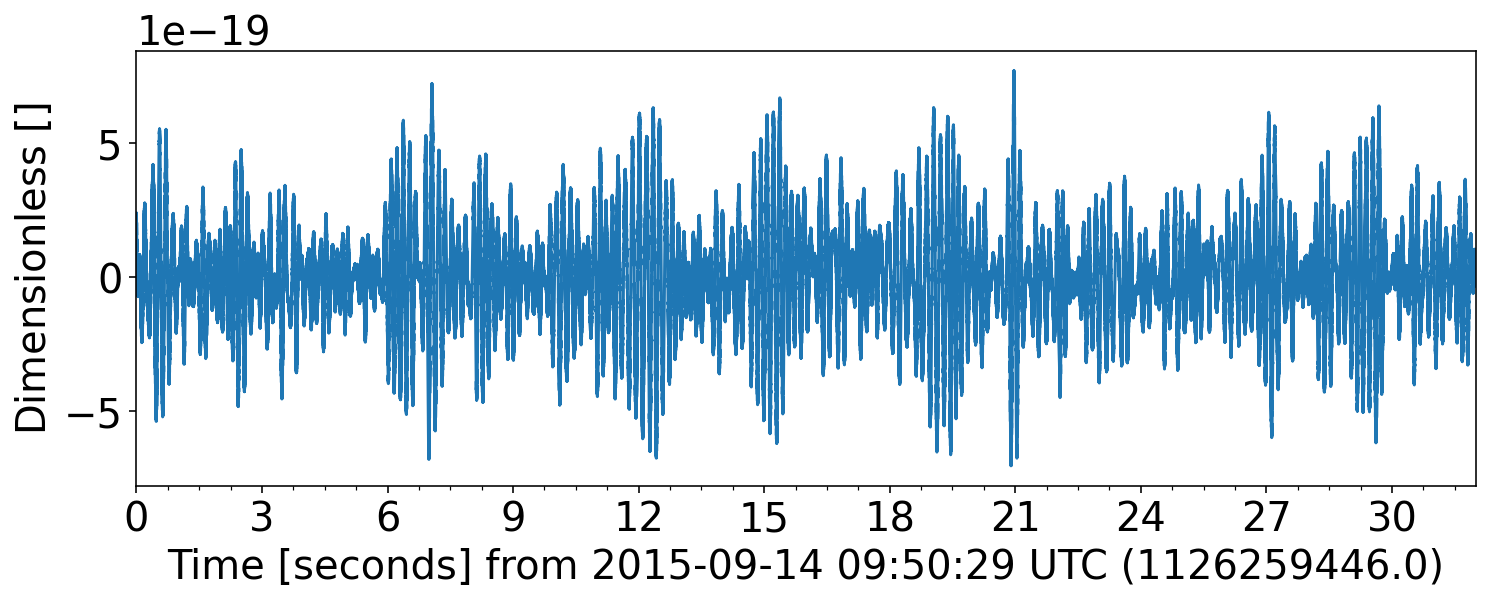

In [32]:
# -- Read strain data
strain = TimeSeries.read(fn,format='hdf5.losc')
center = int(t0)
strain = strain.crop(center-16, center+16)
fig1 = strain.plot()

The strain is a dimensionless quantity. Recall,


---


* $\text{strain} = \frac{\Delta L}{L}$


---


Where $L$ is the arm length of the interferometer.

The gravitational-wave event GW150914 occurs at 0s.

We will study the signal and its properties in a subsequent section. For now, let's build some intuition for the data itself.

First, notice the scale. The characteristic strain of our data is 

* $\text{strain}_{\text{data}}\sim \mathcal{O}(10^{-19})$

As we'll see, the typical strain of a $\textit{detectable}$ GW signal from, e.g., a binary black hole merger is

* $\text{strain}_{\text{BBH}} \sim \mathcal{O}(10^{-21})$ 

How can we resolve signals that are significantly smaller than the scale of the data? There are a few answers to this. One of them has to do with how the noise behaves at particular frequencies. As we'll see, the instruments are "quieter" in the audio band ($20\text{Hz}-1024\text{Hz}$) than at lower or higher frqeuencies. 

# Spectral properties

### Power Spectral Density and Amplitude Spectral Density

The scale of the data are dominated by low-frequency noise. This isn't clear from the time series, but we can gain more insight by looking at the $\textbf{Power Spectral Density (PSD)}$ of the data. 

The following description is from GWOSC:


    The PSD is the time-average of the square of the fourier transform (FT) of the data.

    They are an estimate of the "strain-equivalent noise" of the detectors versus frequency, which limit the ability of the detectors to identify GW signals.

The PSD is in units of $\text{strain}/(\text{Hz})$. 

Usually, we summarize the spectral properties in terms of the $\textbf{Amplitude Spectral Density}$ which is the square root of the PSD. The ASD has units of $\text{strain}/(\sqrt{\text{Hz}})$. If you want to know the root-mean-square (rms) strain noise in a frequency band, integrate (sum) the squares of the ASD over that band, then take the square-root.

There's a signal in these data! For the moment, let's ignore that, and assume it's all noise.

Text(0.5, 1.0, 'Noise Amplidude Spectral Density (ASD)')

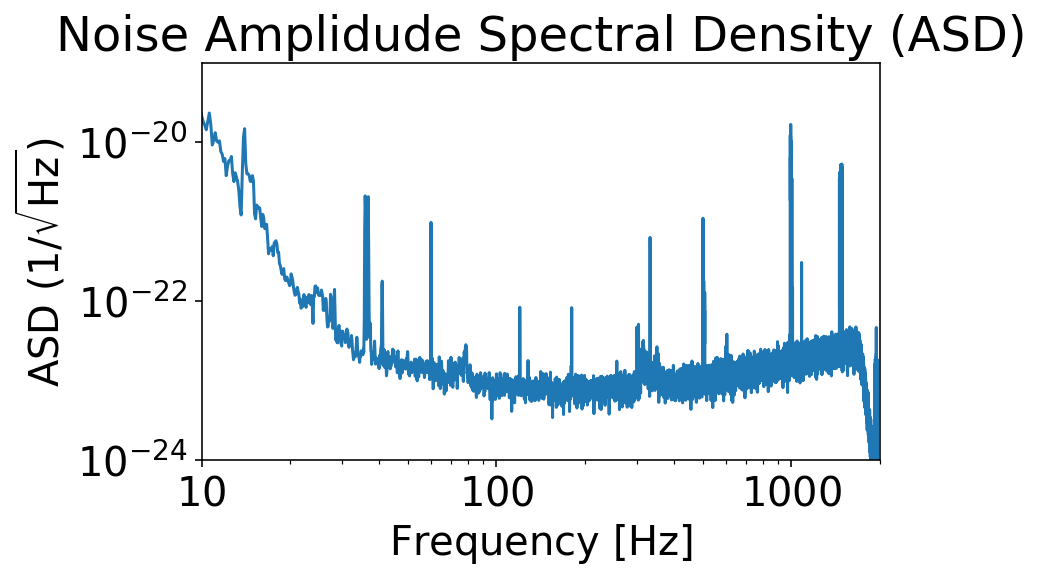

In [35]:
# -- Plot ASD
# fft length of 8 sec
fig2 = strain.asd(fftlength=8).plot()
plt.xlim(10,2000)
plt.ylim(1e-24, 1e-19)
plt.ylabel("ASD ($1/\sqrt{\mathrm{Hz}}$)")
plt.title("Noise Amplidude Spectral Density (ASD)")

Notice that the strain amplitude spectral density in this band looks like it's at the right scale for a "typical" BBH merger signal. Qualitatively, this suggests that we can pick out an astrophysical signal whose amplitude is much lower than the typical scale of the noise in the data.

In addition to the ASD, one frequently encounters the noise Power Spectral Density, or PSD. This is just the square of the ASD.


Text(0.5, 1.0, 'Noise Power Spectral Density (PSD)')

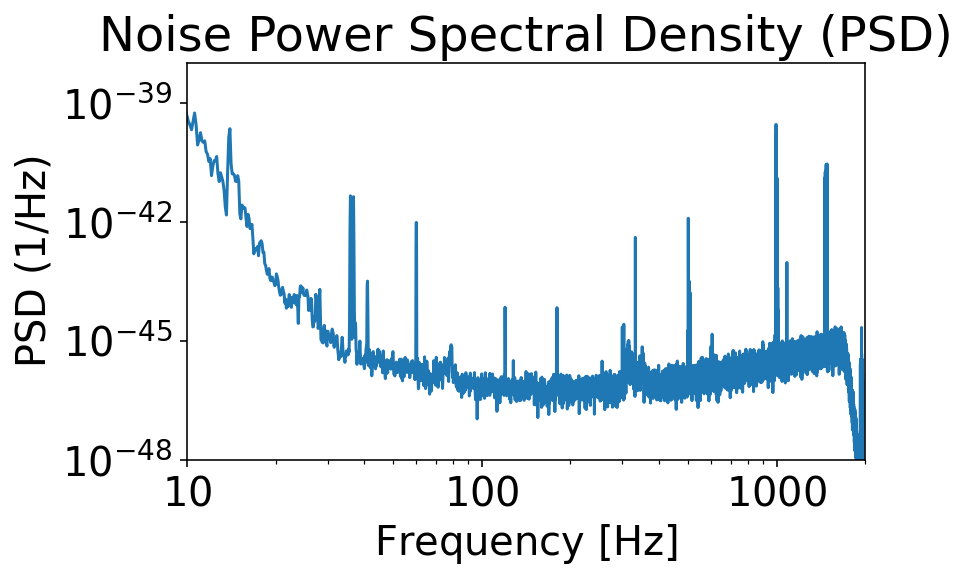

In [38]:
# -- Plot ASD
# fft length of 8 sec
fig2 = strain.psd(fftlength=8).plot()
plt.xlim(10,2000)
plt.ylim(1e-24**2, 1e-19**2)
plt.ylabel("PSD ($1/\mathrm{Hz}$)")
plt.title("Noise Power Spectral Density (PSD)")

The PSD and ASD are useful quantities for two reasons. First, the can be computed from the physics of the known noise sources (see the last code cell of this notebook). Second, they characterize the statistical properties of the detector noise. The variance of the detector noise is directly proportional to the PSD.  

If we look at the real and imaginary components of the Fourier data, they're distributed about zero. To begin, we need to first FFT the data. Let's do this manually for a few chunks of the time-domain strain data


In [34]:
#this splits the data into chunks
chunk_up_data = lambda A, n=int(1024): [A[i:i+n] for i in range(0, len(A), n)]

strain_chunks = chunk_up_data(strain)

T = len(strain_chunks[0])*strain.dt
df = 1/T # frequency resolution (from Nyquist theorem)

window = signal.windows.tukey(len(strain_chunks[0]))

T = len(strain_chunks[0])*strain.dt
df = 1/T # frequency resolution (from Nyquist theorem)
window = signal.windows.tukey(len(strain_chunks[0]))
_FT = np.array([np.fft.rfft(strain_chunks[i]*window) for i in range(len(strain_chunks))])/(len(strain)*df) 
# NOTE: The scaling by (len(strain)*df) is because of how numpy normalizes its
# FFT and inverse FFT
#20/delta f



* In fact, the real and imaginary components of the noise in the frequency domain are normally distributed with

  * mean $\mu=0$
  * variance $\sigma(f)^2 = \text{PSD}(f)/(4\Delta f) = 2\text{PSD}(f)/T$
  
  We'll use the following notation
  
* $\text{Re}\, n(f_k) \sim \mathcal{N}(\mu=0,\sigma(f_k)) \,\forall\, f_k $
* $\text{Im}\, n(f_k) \sim \mathcal{N}(\mu=0,\sigma(f_k)) \,\forall\, f_k $

Which is often used in the statistics literature

  

## Spectogram

The time and Fourier data aren't especially by themselves revealing. However, if we look at a spectogram, we can better visualize the time-frequency space and see a hint of a signal

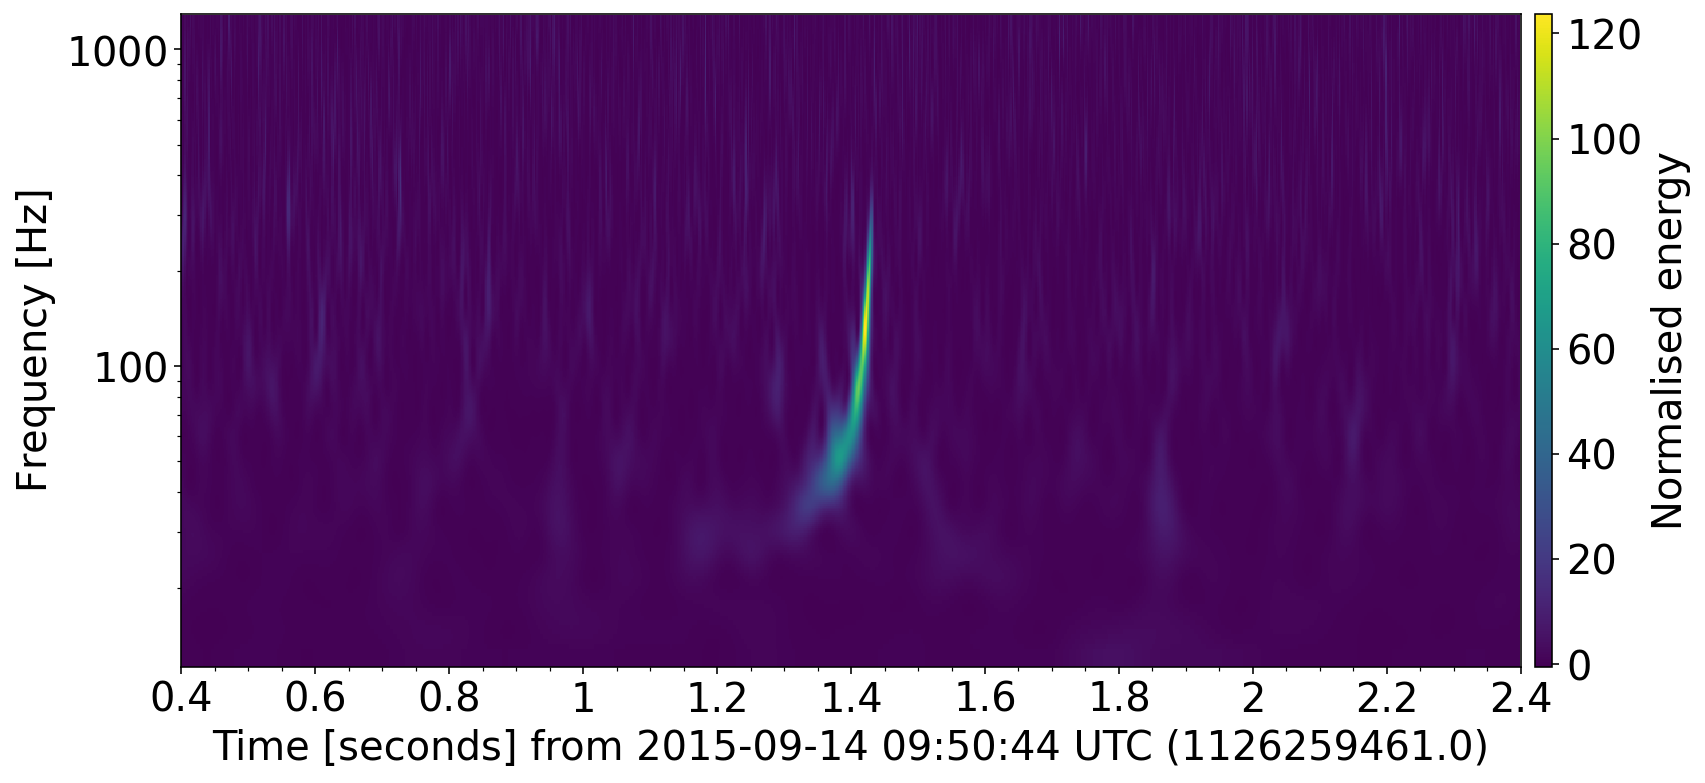

In [39]:
dt = 1  #-- Set width of q-transform plot, in seconds
hq = strain.q_transform(outseg=(t0-dt, t0+dt))
fig4 = hq.plot()
ax = fig4.gca()
fig4.colorbar(label="Normalised energy")
ax.grid(False)
ax.set_yscale('log')

This spectrogram more clearly highlights the GW150914 signal because it normalises the frequency domain data by the ASD. This has the effect of re-scaling the noise at each frequency to the same scale. When a signal is present, this rescaling clearly shows the signal amplitude relative to the noise. This process is called "whitening". If we look at the whitened signal in the time-domain, we can much more clearly see GW150914. Again, this is becasue the data have been scaled by the typical noise amplitude.

(1126259462.2, 1126259462.5)

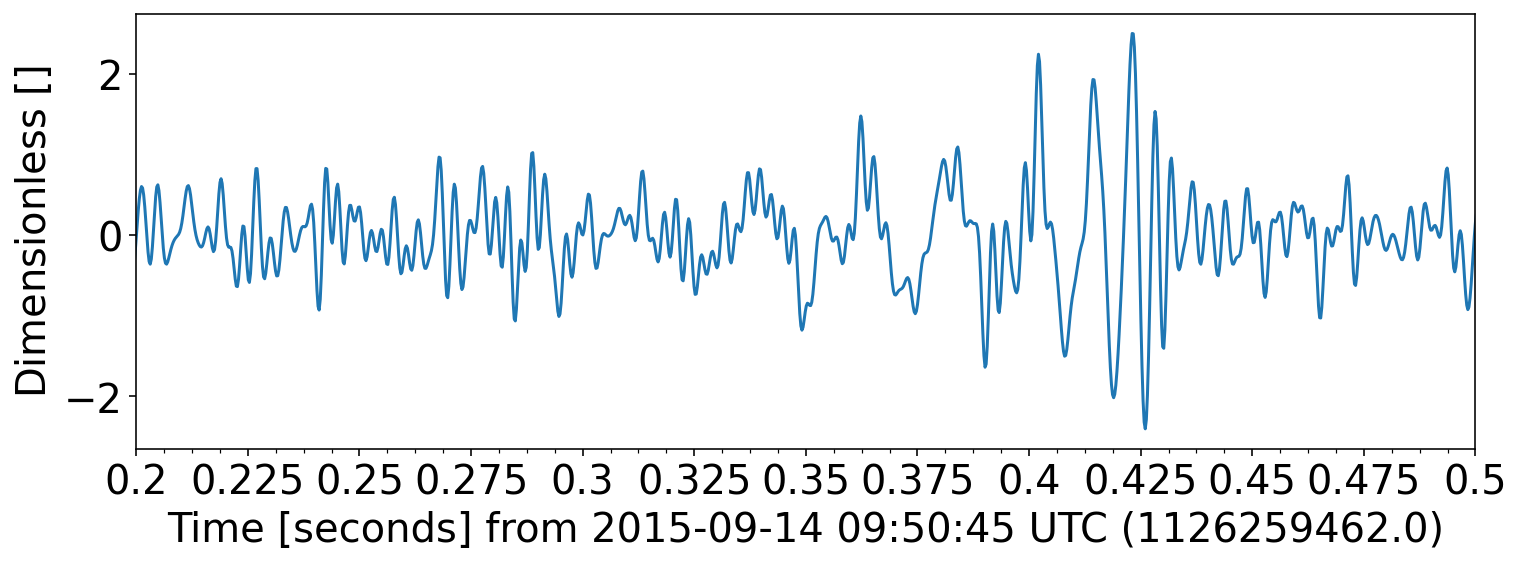

In [40]:
# -- Whiten and bandpass data
white_data = strain.whiten()
bp_data = white_data.bandpass(30, 400)
fig3 = bp_data.plot()
plt.xlim(t0-0.2, t0+0.1)

## Components of the aLIGO PSD/ASD 

The plot below is the projection of the "design sensitivity" noise curve. It's the result of a combination of a number of independentent noise sources that add in quadrature:


<img src="https://docs.google.com/uc?export=download&id=1EUcnrwWxxX_FaOzfSXK87qaiv5Kb1PxT" width="400">